In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
class Layer(torch.nn.Module):
    """A simple feedforward layer with an activation function."""
    def __init__(self, n_feature, n_hidden, activation_function=None):
        super().__init__()

        self.linear = torch.nn.Linear(n_feature, n_hidden)

        if activation_function is None:
            self.activation_function = torch.nn.Identity()
        else:
            self.activation_function = activation_function

    def forward(self, x):
        out = self.linear(x)
        out = self.activation_function(out)
        return out


class FeedForward(torch.nn.Module):
    """A simple feedforward neural network with two hidden layers."""
    def __init__(self, n_feature, n_hidden, n_output, activation_function):
        super().__init__()

        self.layer0 = Layer(n_feature=n_feature, n_hidden=n_hidden, activation_function=activation_function)
        self.layer1 = Layer(n_feature=n_hidden, n_hidden=n_hidden, activation_function=activation_function)
        self.layer2 = Layer(n_feature=n_hidden, n_hidden=n_output, activation_function=None)

    def forward(self, x):
        # (b, f) -> (b, h)
        out = self.layer0(x)
        # (b, h) -> (b, h)
        out = self.layer1(out)
        # (b, h) -> (b, o)
        out = self.layer2(out)
        return out


In [11]:
# Create a random input tensor
x = torch.rand(10000, 3)
y = 10 + 2 * x[:, 0] + 3 * x[:, 1] + 4 * x[:, 2] ** 0.5 + torch.randn(10000) * 0.0001

x_train = x[:8000]
y_train = y[:8000]
x_val = x[8000:]
y_val = y[8000:]

In [12]:
# Create a loss function
loss_fn = torch.nn.MSELoss()

# Create a feedforward neural network
feedforward = FeedForward(n_feature=3, n_hidden=4, n_output=1, activation_function=torch.nn.ReLU())

# Create an optimizer
optimizer = torch.optim.AdamW(feedforward.parameters(), lr=0.01, weight_decay=0.0)

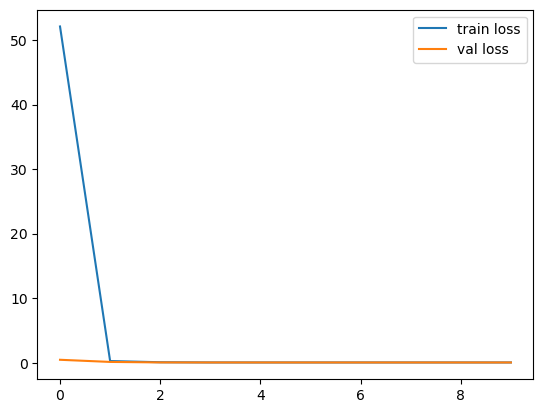

In [13]:
batch_size = 32

train_losses = []
val_losses = []


for epoch in range(10):
    random_index = torch.randperm(len(x_train))
    x_train = x_train[random_index]
    y_train = y_train[random_index]

    train_epoch_losses = []
    val_epoch_losses = []

    # Training loop.
    feedforward.train()  # Set the model to training mode.
    for start_index in range(0, len(x_train), batch_size):
        end_index = start_index + batch_size
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]

        # Reset gradients.
        optimizer.zero_grad()

        # Forward pass.
        y_pred = feedforward(x_batch)

        # Compute loss.
        loss = loss_fn(y_pred.squeeze(), y_batch)

        # Backward pass.
        loss.backward()

        # Update weights.
        optimizer.step()

        train_epoch_losses.append(loss.item())

    # Validation loop.
    feedforward.eval()  # Set the model to evaluation mode.
    with torch.no_grad():
        for start_index in range(0, len(x_val), batch_size):
            end_index = start_index + batch_size
            x_batch = x_val[start_index:end_index]
            y_batch = y_val[start_index:end_index]

            y_val_pred = feedforward(x_val)
            val_loss = loss_fn(y_val_pred.squeeze(), y_val)

            val_epoch_losses.append(val_loss.item())

    train_losses.append(sum(train_epoch_losses) / len(train_epoch_losses))
    val_losses.append(sum(val_epoch_losses) / len(val_epoch_losses))


plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()

Text(0, 0.5, 'Predicted values')

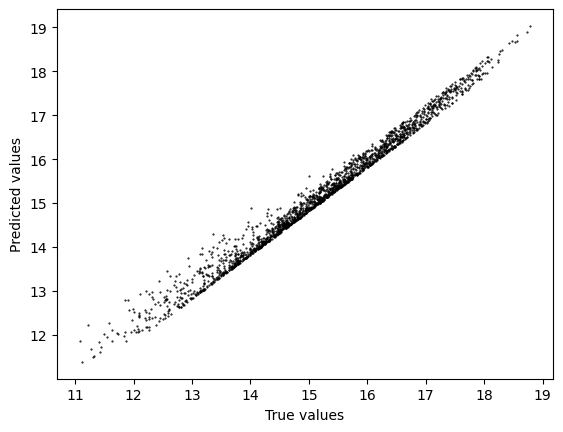

In [14]:
feedforward.eval()  # Set the model to evaluation mode.

# Predict and detach the tensor from the computational graph and convert it to a NumPy array.
y_hat = feedforward(x_val).detach().numpy()

plt.plot(y_val, y_hat, 'o', markersize=0.5, color='black')
plt.xlabel('True values')
plt.ylabel('Predicted values')